In [ ]:
# DEMAND PREDICTION for Capital Bikeshare- Washington, D.C 

# Data taken from Kaggle: https://www.kaggle.com/c/bike-sharing-demand/data

,weather,temp,humidity,windspeed,count
0,1,9.84,81,0.0000,16.0
1,1,9.02,80,0.0000,40.0
2,1,9.02,80,0.0000,32.0
3,1,9.84,75,0.0000,13.0
4,1,9.84,75,0.0000,1.0
...,...,...,...,...,...
10881,1,15.58,50,26.0027,336.0
10882,1,14.76,57,15.0013,241.0
10883,1,13.94,61,15.0013,168.0
10884,1,13.94,61,6.0032,129.0


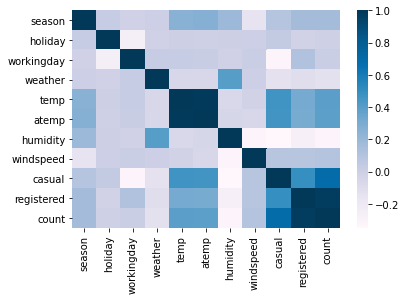

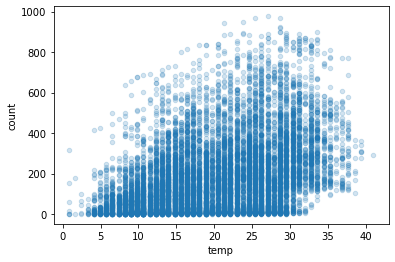

In [2]:
# 1. Load required libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import pickle

# 2. Load and prepare data

# Load the data 
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv' 
bikes = pd.read_csv(url)

# Review data
sns.heatmap(bikes.corr(), annot= False, cmap='PuBu')
bikes.plot(kind='scatter', x='temp', y='count', alpha=0.2)

# Clean data: 

# a) 
bikes= bikes.dropna(axis=0, how='any', thresh=None, subset=['count'], inplace=False) # missing values 
bikes['count']=np.where(bikes['count']<0,bikes['count'].mean(),bikes['count']) # incorect values 
# b)
bikes = bikes.drop_duplicates(['datetime']) # duplicates
# c)
bikes.drop(['registered','casual','datetime','season','holiday','workingday','atemp'], axis = 1, inplace = True) # redundant columns

bikes


In [3]:
# 3. Define response variable
Y = bikes['count'] 

# 4. Define predictor variables
feature_cols = ['temp','humidity','windspeed','weather'] # a list of the predictors
X = bikes[feature_cols] # subsetting our data to only the predictors

# 5. Define baseline ML algorithms
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # split the data into training and testing sets

linreg = LinearRegression() #instantiate a new LR model
linreg.fit(X_train, Y_train) 
Y_lr = linreg.predict(X_test) 

rf = RandomForestRegressor(max_depth=4) #instantiate a new RF model
rf.fit(X_train, Y_train) 
Y_rf = rf.predict(X_test) 

In [4]:
# 6. Interpret ML model

# Evaluate the null model
average_bike_rental = bikes['count'].mean()
average_bike_rental
num_rows = bikes.shape[0]
num_rows
null_model_predictions = [average_bike_rental]*num_rows
null_model_predictions
print('nullRMSE is', np.sqrt(metrics.mean_squared_error(Y, null_model_predictions)))

# Evaluate baseline ML models
print('lrRMSE is', np.sqrt(metrics.mean_squared_error(Y_test, Y_lr))) # RMSE
print('rfRMSE is', np.sqrt(metrics.mean_squared_error(Y_test, Y_rf))) # RMSE

# Print linear model parameters
print('LR intercept is',linreg.intercept_) # our linear Beta_0
result = zip(feature_cols, linreg.coef_) # pair the feature names with the LR coefficients
resultSet = set(result)
print('LR coefficients are', resultSet)

nullRMSE is 181.1361335742659
lrRMSE is 158.41288534486262
rfRMSE is 154.85823447080102
LR intercept is 181.4980605952721
LR coefficients are {('humidity', -2.798775890189987), ('weather', 3.543866453577162), ('temp', 8.714432306540237), ('windspeed', 0.15912080771673237)}


In [5]:
# Store results in a dataframe
TestingData=pd.DataFrame()
TestingData['lr_prediction']=Y_lr
TestingData['rf_prediction']=Y_rf
TestingData['demand']=Y_test
features= ['temp','humidity','windspeed','weather']
TestingData[features]= X_test

<AxesSubplot:xlabel='temp', ylabel='demand'>

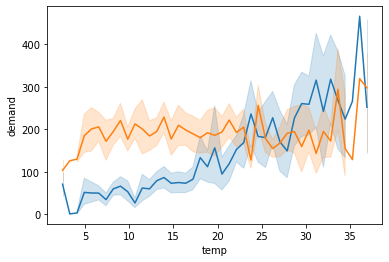

In [6]:
# Visualize results (do poprawy) 
sns.lineplot(data=TestingData, x="temp", y="demand")
sns.lineplot(data=TestingData, x="temp", y="rf_prediction")

<AxesSubplot:xlabel='humidity', ylabel='demand'>

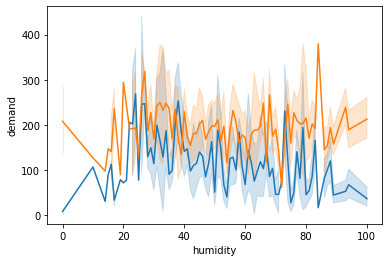

In [7]:
sns.lineplot(data=TestingData, x="humidity", y="demand")
sns.lineplot(data=TestingData, x="humidity", y="rf_prediction")

<AxesSubplot:xlabel='windspeed', ylabel='demand'>

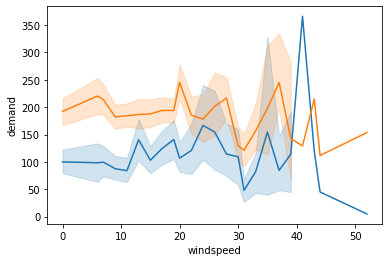

In [8]:
sns.lineplot(data=TestingData, x="windspeed", y="demand")
sns.lineplot(data=TestingData, x="windspeed", y="rf_prediction")

In [9]:
# 7. Optimize ML model

# Feature selection

k_best=[1, 2, 3, 4]

for no_features in k_best: # find best number of features
    fs = SelectKBest(score_func=f_regression, k=no_features) # define filtering method
    X_selected = fs.fit_transform(X, Y) # apply feature selection
    X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y) # split the data into training and testing sets
    rf2 = RandomForestRegressor(max_depth=4) #instantiate a new RF model
    rf2.fit(X_train, Y_train) 
    Y_rf2 = rf2.predict(X_test)
    print('for k_best =',no_features, 'rf2RMSE is', np.sqrt(metrics.mean_squared_error(Y_test, Y_rf2))) 

for k_best = 1 rf2RMSE is 164.4874164243733
for k_best = 2 rf2RMSE is 153.38026668269904
for k_best = 3 rf2RMSE is 149.46735249622645
for k_best = 4 rf2RMSE is 154.66797949650405


In [10]:
fs = SelectKBest(score_func=f_regression, k=3) # apply best number of features
X_selected = fs.fit_transform(X, Y) # apply feature selection 
print(X_selected)

[[ 9.84 81.    1.  ]
 [ 9.02 80.    1.  ]
 [ 9.02 80.    1.  ]
 ...
 [13.94 61.    1.  ]
 [13.94 61.    1.  ]
 [13.12 66.    1.  ]]


In [11]:
# Hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

rf3 = RandomForestRegressor() # instantiate a new RF model
# Listing all the parameters to try
Parameter_Trials={'max_depth':[2,4,64,None],
                  'n_estimators': [200,400,1600],
                  'max_features':['auto', 'log2']
                 }

def Accuracy_Score(orig,pred):
    RMSE = np.sqrt(metrics.mean_squared_error(orig, pred))
    print('#'*3,'Error:', RMSE)
    return(RMSE)

custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=False)

# Creating the Grid search space
grid_search=GridSearchCV(estimator=rf3, 
                        param_grid=Parameter_Trials, 
                         scoring=custom_Scoring, 
                        cv=5)

# Running Grid Search for different paramenters

grid_search.fit(X_selected,Y)

print('### Printing Best parameters ###')
grid_search.best_params_

### Error: 127.64233266495279
### Error: 158.64248311492838
### Error: 119.7059526830695
### Error: 208.17802224866074
### Error: 217.64773609489615
### Error: 127.43370182548568
### Error: 158.21521182400232
### Error: 119.86069949519087
### Error: 208.08680120067203
### Error: 217.7506384356672
### Error: 127.38848825131672
### Error: 158.19095585043493
### Error: 119.79209065460687
### Error: 207.91568973493582
### Error: 217.7152062559144
### Error: 139.39162905039748
### Error: 146.20968542928475
### Error: 124.61499883545403
### Error: 215.9120091739574
### Error: 222.56017158618442
### Error: 138.62156259857605
### Error: 144.8139510525592
### Error: 124.22659183899962
### Error: 216.70177947332346
### Error: 222.44536002342164
### Error: 138.11267442488207
### Error: 145.18700555981323
### Error: 124.11868992948511
### Error: 216.0200195417889
### Error: 222.13556676254308
### Error: 116.8603870309379
### Error: 157.77476121419878
### Error: 116.51738031139473
### Error: 196.85

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 400}

In [49]:
# 7. Save ML model 

rf_best = RandomForestRegressor(max_depth=4, max_features='auto', n_estimators=400) # instantiate a best performing RF model
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y) # split the data into training and testing sets
rf_best.fit(X_train, Y_train)

filename = 'Capital Bikeshare_demand_prediction.sav'
pickle.dump(rf_best, open(filename, 'wb')) # use best model as an independent application

# Check the model 
loaded_model = pickle.load(open(filename, 'rb'))
new_input = [[25, 78, 1]]
result = loaded_model.predict(new_input) 
print(result)

[142.07312849]
